# Imports

In [1]:
#%run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb
%run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb

import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

import gbm
from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

#%matplotlib inline

All MAC paths are set!


ModuleNotFoundError: No module named 'gbm'

CSPEC: data with a course time resulution --- with a good spectral resolution 

CTIME: they have course spectral resulution (8 channels) but a hight time resolution

# Paths

In [2]:
GRB_id = "GRB210619B"
bn='bn210619999' #what is this? GRB id for Fermi
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

# Find the angle of the GRB wrt the GBM units

In [3]:
fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit
trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)

glg_trigdat_all_bn210619999_v01.fit
645839970.604186


In [4]:
# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

['n2', 'n3', 'n4', 'n7', 'n8']


In [5]:
grb_ra, grb_dec = 319.716, 33.85  #put in manually

In [6]:
all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?


# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix


# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function

n8 25.951
n4 50.99
n7 68.489
nb 71.936
b1 75.565
n3 83.873
n6 90.944
b0 104.435
n5 107.66
n9 124.021
n0 126.454
na 128.196
n1 144.321
n2 155.105


# Find temporal offset between GBM trigger time and others

In [7]:
#imports relevant modules
from gbm.time import Met
import datetime

# Convert from MET to UTC
t0METgbm = Met(trigdat.trigtime) #middle european time?
print(t0METgbm)
print(type(t0METgbm)) #checking which type it is
print(t0METgbm.datetime) #interesting that is already an datetime object?

<Met seconds = 645839970.604186>
<class 'gbm.time.Met'>
2021-06-19 23:59:25.604186+00:00


In [8]:
ToF_Fermi_ASIM = 0.0227 #light travel time in seconds
ToF_KW_ASIM = -2.6183
str_t0KW = '2021-06-19T23:59:28.157' #T0 for KW

str_t0ASIM = '2021-06-19T23:59:25.915550'

t0METASIM = t0METgbm.from_iso(str_t0ASIM)

#t0METKW = t0METgbm.from_iso(str_t0KW) #Converting T0 KW to T0 met
print("t0METASIM: ", t0METASIM)
print("ToF",ToF_Fermi_ASIM)
#Q: Why are we adding both ToF? Double check this
t0MET = t0METASIM.add(ToF_Fermi_ASIM)  # To add seconds
print("t0MET in ASIM ref frame: ", t0MET)
tshift = t0MET - t0METgbm
print("tshift: ", round(tshift,6)) #if positive: added to t0GBM to bring it into ASIM ref frame 

t0METASIM:  <Met seconds = 645839970.915550>
ToF 0.0227
t0MET in ASIM ref frame:  <Met seconds = 645839970.938250>
tshift:  0.334064


#  Extract data from selected unit(s)+

In [9]:
unit = all_dets[idx_sort_angsep][2]
#unit = trig_dets[0] #unit of the first trigger detector. What unit is this?
print(unit)

# Read TTE of selected unit
#Q: what is TTE? Time-Tagged Event. Assuming its that same as the tus array in ASIM data
fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'

# Filename of RSP for the selected unit
# Q: getting the filename for the response matirx? 
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' 
#make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

n7


In [10]:
tte = TTE.open(fn_tte)

# certain useful properties are easily accessible
print("GTI: {}".format(tte.gti))
print("Trigger time: {}".format(tte.trigtime))
print("Time Range: {}".format(tte.time_range))
print("Energy Range: {}".format(tte.energy_range))
#print('# of Energy Channels: {}'.format(tte.numchan))

GTI: [[-138.3701640367508, 476.04186594486237]]
Trigger time: 645839970.604186
Time Range: (-138.3701640367508, 476.04186594486237)
Energy Range: (4.4444437, 2000.0)


In [11]:
# TODO: Shift the tte data by tshift!
# Modify the original photon array. Then create a new EventList object by passing in the modified array + the other necccecary lists
#You can do the time shift, and then create a new EventList with the shifted times and the corresponding channel numbers 

def shift_tte(tte=None,tshift=None):
    pha = tte.to_pha()
    new_trigtime = tte.trigtime + tshift
    eventList = gbm.data.primitives.EventList.from_lists(tte.data.time + tshift, tte.data.pha, pha.data.lo_edges,pha.data.hi_edges)
    new_tte = TTE.from_data(eventList,trigtime=new_trigtime)
    return new_tte

In [12]:
new_tte = shift_tte(tte=tte,tshift=tshift)

In [13]:
new_tte.trigtime

645839970.93825

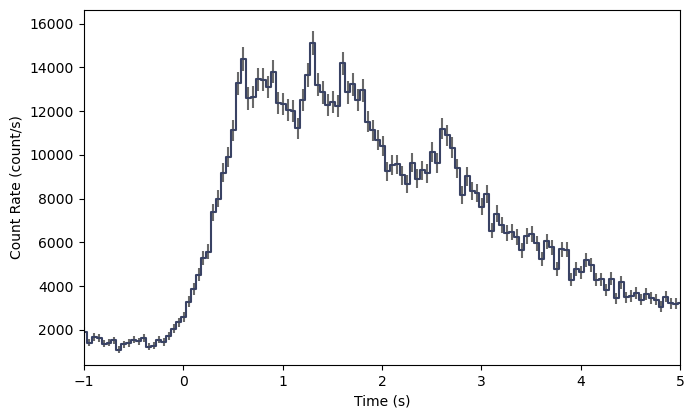

In [14]:
# open a TTE file and change the trigtime manually.
#See docs at https://fermi.gsfc.nasa.gov/ssc/data/analysis/gbm/gbm_data_tools/gdt-docs/api/api-data.html#tte 

bint = 0.05 # 2ms binning
#phaii = tte.to_phaii(bin_by_time, bint, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time, bint) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (8,1000) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-1,5)

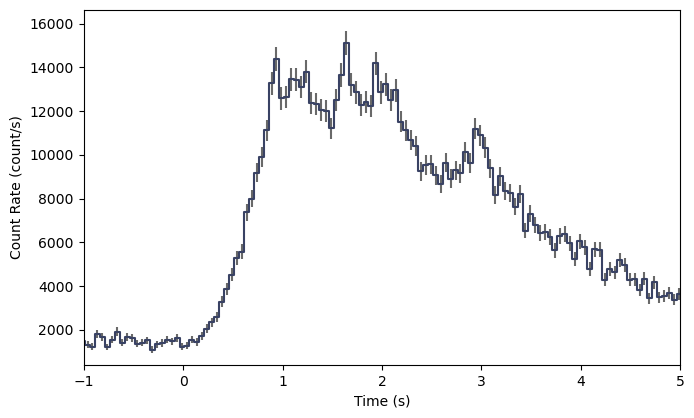

In [15]:
# open a TTE file and change the trigtime manually.
#See docs at https://fermi.gsfc.nasa.gov/ssc/data/analysis/gbm/gbm_data_tools/gdt-docs/api/api-data.html#tte 

bint = 0.05 # 2ms binning
#phaii = tte.to_phaii(bin_by_time, bint, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = new_tte.to_phaii(bin_by_time, bint) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (8,1000) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-1,5)

In [16]:
# Fit background
bkgd_times = [(-130,-5)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 

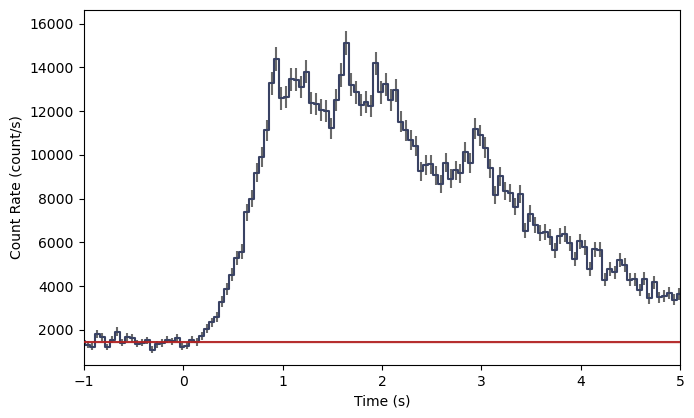

In [17]:
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
#type(bkgd)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-1, 5)
lcplot.xlim = view_range

In [18]:
# Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).
backfitter.statistic/backfitter.dof

array([ 7.51648615,  1.87643861,  1.60214377,  1.35731408,  1.05713136,
        0.8886433 ,  0.90335713,  0.85914328,  0.83741428,  0.85882142,
        0.85998812,  0.84841292,  0.89351244,  0.85088149,  0.8621552 ,
        0.85176479,  0.86504184,  0.79912105,  0.83826515,  0.86704826,
        0.84046374,  0.84790786,  0.8382025 ,  0.85495965,  1.01300651,
        0.98923268,  1.13064321,  1.24357646,  1.38723175,  1.35953941,
        1.34808813,  1.6137653 ,  1.63246637,  1.42279688,  1.49838371,
        1.48997013,  1.78669257,  1.51113131,  1.46171031,  1.42694854,
        1.36086156,  1.43018412,  1.6019316 ,  1.73509365,  1.8228448 ,
        1.86467555,  1.88286298,  1.90976681,  2.17560335,  2.02919141,
        2.31385185,  2.59971981,  2.41785146,  2.42388137,  2.30809536,
        2.53047571,  2.60751429,  2.50177802,  2.62517657,  2.62946208,
        2.70095644,  2.87048504,  2.86427612,  2.61555082,  3.11820693,
        2.95918662,  2.74192427,  3.14619641,  2.33351438,  2.71

In [19]:
# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])))[0] #removed: | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1]))
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])))[0] #removed | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) 

Normalised residuals: mean= 5.5e-05  std= 1.01
NormaltestResult(statistic=1.5282631554598216, pvalue=0.46573821284128036)


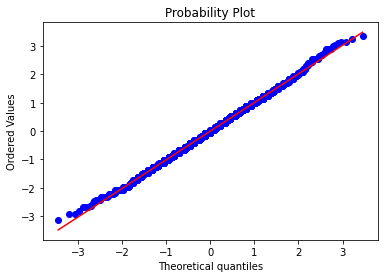

In [20]:
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))

#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

In [21]:
# Now, we need to define a time interval of interest.  It could be a single bin, or it could be multiple bins.  Let's select the brightest two bins in this view.
# our lightcurve source selection

src_time = (1, 1.7) # T0+1 to T0+1.7 s. In the ASIM referance frame
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange) #erange = (150keV-40MeV)

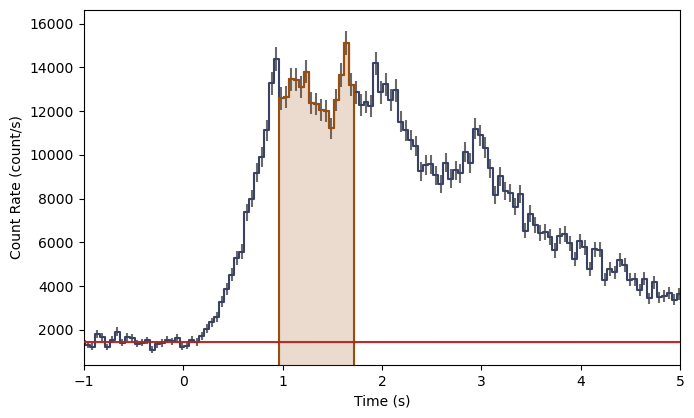

In [22]:
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = (-1,5) #view_range

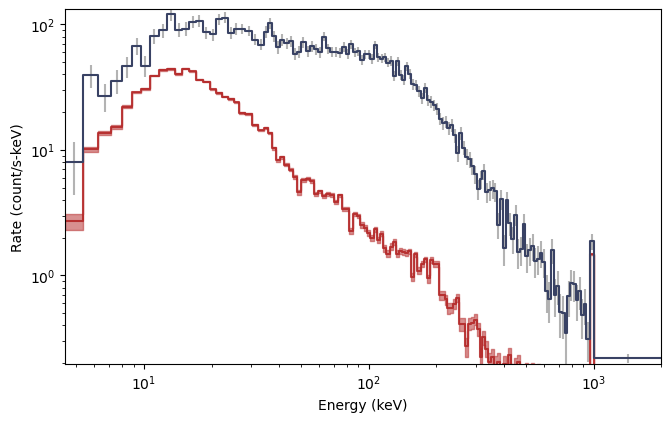

In [23]:
# The orange shading indicates the time bins you've selected as source signal.  You can also make a plot of the count spectrum during the selection  to see what the background model looks like in comparison to the data:
# the observed count spectrum during the source selection
spec_data = new_tte.to_spectrum(time_range=src_time)
#spec_data = phaii.to_spectrum(time_range=src_time)
# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)
# and the energy range selection that was made
#spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)
specplot = Spectrum(data=spec_data, background=spec_bkgd)
#specplot.add_selection(spec_selection)

# Extract fits files

In [24]:
# Extract the corresponding PHA from source and bkg files
pha = new_tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

In [25]:
# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")


fparkey GRB210619B_n7.rsp GRB210619B_n7.pha+2 RESPFILE


In [26]:
# Time intervals for spectra
# Add time shift due to GBM vs. KW reference times

#fn_spec_times = '/home/guidorzi/ASIM/KW_LCs/GRB201227A_sp.txt'
#spec_times = np.loadtxt(fn_spec_times, unpack=True) + tshift
